In [1]:
# Install required libraries

!pip install --upgrade google-api-python-client
!pip install --upgrade google-auth-oauthlib google-auth-httplib2
!pip install isodate
!pip install wordcloud

In [2]:
# install required packages

from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON
import json
import numpy as np

# Data viz packages

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set(style="darkgrid", color_codes=True)

# NLP Libraries

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mahas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Youtube API key

api_key = 'XXXXXX'    # Enter your API key

# For a single channel

In [4]:
# Get the channel's id from Youtube API data

playlist_id = "UU4SVo0Ue36XCfOyb5Lh1viQ"  # (Bro code channel's id)

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client

youtube = build(
    api_service_name, api_version, developerKey = api_key)

In [6]:
def get_channel_stats(youtube, id):
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id="UC4SVo0Ue36XCfOyb5Lh1viQ"    # Bro code channel id

    )
    response = request.execute()
    
    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return (pd.DataFrame(all_data))

In [7]:
 # we can only get 5 id of videos, as it is default  - To increase it, we use maxResults

def get_video_ids1(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 10
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    return video_ids


video_ids1 = get_video_ids1(youtube, playlist_id)


video_ids1  

['CgkZ7MvWUAA',
 'jPo0mIcNZfM',
 'AltU-XcGvuo',
 'FpNfvbNYPsg',
 'AiQ-V_0qvRI',
 'L-1sP3Ljhsg',
 'lfmg-EJ8gm4',
 'VaDUGPMjzOM',
 '37vxWr0WgQk',
 '749ta0nvj8s']

In [8]:
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 10
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    # next_page_token
    # this would give ids of all the videos from the channel
    
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults = 10,
            pageToken = next_page_token
        )
        response = request.execute()
    
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')
    
    return video_ids

In [9]:
def get_video_details(youtube, video_ids):

    all_videos_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id = ','.join(video_ids[i : i+50])
            # id=video_ids[0:5]
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet':['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics':['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails':['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_videos_info.append(video_info)
        
    return pd.DataFrame(all_videos_info)

In [10]:
channel_stats = get_channel_stats(youtube, id)

In [11]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Bro Code,1560000,75996632,682,UU4SVo0Ue36XCfOyb5Lh1viQ


In [12]:
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

682

In [13]:
video_ids        

['CgkZ7MvWUAA',
 'jPo0mIcNZfM',
 'AltU-XcGvuo',
 'FpNfvbNYPsg',
 'AiQ-V_0qvRI',
 'L-1sP3Ljhsg',
 'lfmg-EJ8gm4',
 'VaDUGPMjzOM',
 '37vxWr0WgQk',
 '749ta0nvj8s',
 '3uKdQx-SZ5A',
 'r4MLHHLctKw',
 '9j1dZwFEJ-c',
 'NOzi4wBHn0o',
 '9wiWzu_tRB0',
 'NOlOw03qBfw',
 'J4YhlDsNqeE',
 'd8-LGhKtzRw',
 '62qN2RcpIAE',
 '5n3qPKgLEDc',
 'MkvHPOT4RS8',
 'q32skvBgxo4',
 'g_vXSKbfUiQ',
 'WCRi7y6aNrQ',
 'Y62mbztjmus',
 'A9Bz2YxhAQk',
 'YxQlt3n1ZPA',
 'nbAaUpNDhRY',
 'RKXIMnSwUcg',
 '3hCN3dLHV24',
 'FQtjI1PC5Z0',
 'NO5kUNxGIu0',
 'I5kj-YsmWjM',
 'JhIbXor84Wc',
 'NwoAZF66_Go',
 'Coyy79wRz_s',
 '1cdXwYEFDAg',
 'fl-_6d18DN0',
 'pq_FYp2JSLI',
 'HOMu48bTzz8',
 '2glfqa-ZbNw',
 'PXilNmL9U80',
 '9amAW_qXv84',
 'shWr5DNVeCI',
 'beZfCfiuIkA',
 'LwYwz67l1lA',
 'FGAUekwri1Q',
 'CTHhlx25X-U',
 'w9078dAjcrY',
 'b8gwYQ_V4K4',
 'SpDG283b4bw',
 'UHZcJyVXtLo',
 'KQVCAnh6Afk',
 'Cto38GpvJgg',
 'DqUPa0D2N78',
 'UOH4SAG3BoQ',
 'U2vxAEiaVRY',
 'WPmAu26LZKo',
 'Jdlo8ZDt5Jg',
 'lo7o91qLzxc',
 'fRRRkognpOs',
 'jDqmFt03Gy0',
 'KpiiKu

In [14]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,CgkZ7MvWUAA,Bro Code,React Full Course for free ⚛️ (2024),#reactjs #course #tutorial \n\nThis is a begin...,"[react js, react tutorial, learn react, react ...",2024-01-16T15:55:09Z,109530,5581,None,338,PT4H43M2S,hd,false
1,jPo0mIcNZfM,Bro Code,Build a Stopwatch using React in 20 minutes! ⏱,#reactjs #tutorial #course\n\nThis is a beginn...,"[react js, react tutorial, learn react, react ...",2024-01-14T15:00:35Z,6750,208,None,20,PT20M1S,hd,false
2,AltU-XcGvuo,Bro Code,React useRef() hook introduction 🗳️,#reactjs #tutorial #course \n\n00:00:00 introd...,"[react js, react tutorial, learn react, react ...",2024-01-12T14:00:11Z,2766,106,None,19,PT11M18S,hd,false
3,FpNfvbNYPsg,Bro Code,React useContext() hook introduction 🧗‍♂️,#reactjs #tutorial #course \n\n00:00:00 intro\...,"[react js, react tutorial, learn react, react ...",2024-01-09T18:27:37Z,3549,146,None,38,PT11M37S,hd,false
4,AiQ-V_0qvRI,Bro Code,Build a DIGITAL CLOCK using React in 15 minute...,#reactjs #tutorial #course \n\nThis is a begin...,"[react js, react tutorial, learn react, react ...",2024-01-07T14:00:07Z,7050,237,None,35,PT16M,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,h30Bvg4MhY0,Bro Code,"HTML comments, headings, and spacing 💬 #2","HTML comments, headings, and spacing\n\nCoding...","[html basics, html basics for beginners, html ...",2020-03-25T17:36:28Z,3990,251,None,31,PT15M1S,hd,true
678,QANQHxx9I8Y,Bro Code,C++ variables & data types (#3) ✖️,C++ variables & data types tutorial\n\nCoding ...,"[C++ variables, C++ variables and data types, ...",2020-03-24T00:00:30Z,5890,267,None,21,PT15M21S,hd,true
679,d7t02PbCN_o,Bro Code,"C++ output, comments, and escape sequences (#2) 💬","C++ output, comments, and escape sequences \n\...","[C++ output, C++ output formatting, C++ output...",2020-03-20T22:03:07Z,6303,303,None,14,PT8M21S,hd,true
680,__qv-jK6nno,Bro Code,HTML tutorial for beginners 🌎,HTML tutorial for beginners (2020)\n\ntext edi...,"[HTML, HTML tutorial, HTML tutorial for beginn...",2020-03-20T00:22:05Z,16950,541,None,36,PT11M41S,hd,true


In [15]:
# function to get comments

def get_comments_in_videos(youtube, video_ids):
    all_comments = []
    
    for video_id in video_ids:
        request = youtube.commentThreads().list(
            part = 'snippet, replies',
            videoId = video_id
        )
        response = request.execute()
        
        comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items']]
        comments_in_video_info = {'video_id' : video_id,'comments' : comments_in_video}
        
        all_comments.append(comments_in_video_info)
        
    return pd.DataFrame(all_comments)

In [16]:
comments_df = get_comments_in_videos(youtube, video_ids)
comments_df

,video_id,comments
0,CgkZ7MvWUAA,"[Hi all! Unfortunately, due to time constraint..."
1,jPo0mIcNZfM,[import Stopwatch from './Stopwatch.jsx';\r\n\...
2,AltU-XcGvuo,[// useState() = Re-renders the component when...
3,FpNfvbNYPsg,[// useContext() = React Hook that allows you ...
4,AiQ-V_0qvRI,[import DigitalClock from './DigitalClock.jsx'...
...,...,...
677,h30Bvg4MhY0,"[Sorry if I sound tired in this video, it's be..."
678,QANQHxx9I8Y,[int main()\r\n{\r\n int year = 2020; \r\n ...
679,d7t02PbCN_o,[Hello! Can you make a tutorial for escape roo...
680,__qv-jK6nno,[<!DOCTYPE html>\r\n<html>\r\n\r\n <head>\r\n ...


In [17]:
# Comments of the first video of the channel in the above dataframe

comments_df['comments'][0]

['Hi all! Unfortunately, due to time constraints, I need to discontinue the React series. This video is every lesson compiled from the original playlist. There are more advanced hooks and concepts, but this course should give you at least a solid foundation. Thank you for your support!',
 'any github repo link?',
 'good video!',
 'function Cars(props){\n    return(\n        <div>\n            <p>Name: {props.name} </p>\n          </div>\n    )\n}\nexport default Cars\n\nupper one is cars.jsx for props \nand the lower is app.jsx\n\nimport Cars from \'./Cars.jsx\'\n\nfunction App() {\n  <>\n  <Cars name="BMW"  />\n  </>\n}\n\nexport default App\n\nI dont know wht i am doing wrong pls help me this is from the 4. section props',
 'Can u do a react native series as well',
 'Hi bro code love ur react series I wish tho u could continue',
 'no redux?',
 "hi man! I just wanna ask, I want to freelancing web apps, I've learnt and understand html, css, js, react, tailwind, git. should I learn next

# DATA PRE-PROCESSING

In [18]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [19]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [20]:
# To convert columns dtype to numeric, as per general understandings

numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [21]:
# Publish day in the week

# Assuming video_df is a DataFrame with a 'publishedAt' column containing date strings

video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt'])
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [22]:
# convert duration to seconds

import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

In [23]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,16982.0,PT4H43M2S
1,1201.0,PT20M1S
2,678.0,PT11M18S
3,697.0,PT11M37S
4,960.0,PT16M
...,...,...
677,901.0,PT15M1S
678,921.0,PT15M21S
679,501.0,PT8M21S
680,701.0,PT11M41S


In [24]:
# Add tag count

video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [25]:
# To check if everything worked

video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagCount
0,CgkZ7MvWUAA,Bro Code,React Full Course for free ⚛️ (2024),#reactjs #course #tutorial \n\nThis is a begin...,"[react js, react tutorial, learn react, react ...",2024-01-16 15:55:09+00:00,109530.0,5581.0,NaN,338.0,PT4H43M2S,hd,false,Tuesday,16982.0,19
1,jPo0mIcNZfM,Bro Code,Build a Stopwatch using React in 20 minutes! ⏱,#reactjs #tutorial #course\n\nThis is a beginn...,"[react js, react tutorial, learn react, react ...",2024-01-14 15:00:35+00:00,6750.0,208.0,NaN,20.0,PT20M1S,hd,false,Sunday,1201.0,21
2,AltU-XcGvuo,Bro Code,React useRef() hook introduction 🗳️,#reactjs #tutorial #course \n\n00:00:00 introd...,"[react js, react tutorial, learn react, react ...",2024-01-12 14:00:11+00:00,2766.0,106.0,NaN,19.0,PT11M18S,hd,false,Friday,678.0,21
3,FpNfvbNYPsg,Bro Code,React useContext() hook introduction 🧗‍♂️,#reactjs #tutorial #course \n\n00:00:00 intro\...,"[react js, react tutorial, learn react, react ...",2024-01-09 18:27:37+00:00,3549.0,146.0,NaN,38.0,PT11M37S,hd,false,Tuesday,697.0,21
4,AiQ-V_0qvRI,Bro Code,Build a DIGITAL CLOCK using React in 15 minute...,#reactjs #tutorial #course \n\nThis is a begin...,"[react js, react tutorial, learn react, react ...",2024-01-07 14:00:07+00:00,7050.0,237.0,NaN,35.0,PT16M,hd,false,Sunday,960.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,h30Bvg4MhY0,Bro Code,"HTML comments, headings, and spacing 💬 #2","HTML comments, headings, and spacing\n\nCoding...","[html basics, html basics for beginners, html ...",2020-03-25 17:36:28+00:00,3990.0,251.0,NaN,31.0,PT15M1S,hd,true,Wednesday,901.0,12
678,QANQHxx9I8Y,Bro Code,C++ variables & data types (#3) ✖️,C++ variables & data types tutorial\n\nCoding ...,"[C++ variables, C++ variables and data types, ...",2020-03-24 00:00:30+00:00,5890.0,267.0,NaN,21.0,PT15M21S,hd,true,Tuesday,921.0,12
679,d7t02PbCN_o,Bro Code,"C++ output, comments, and escape sequences (#2) 💬","C++ output, comments, and escape sequences \n\...","[C++ output, C++ output formatting, C++ output...",2020-03-20 22:03:07+00:00,6303.0,303.0,NaN,14.0,PT8M21S,hd,true,Friday,501.0,9
680,__qv-jK6nno,Bro Code,HTML tutorial for beginners 🌎,HTML tutorial for beginners (2020)\n\ntext edi...,"[HTML, HTML tutorial, HTML tutorial for beginn...",2020-03-20 00:22:05+00:00,16950.0,541.0,NaN,36.0,PT11M41S,hd,true,Friday,701.0,15


# EDA

C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 128013 (\N{SNAKE}) missing from current font.
  func(*args, **kwargs)
C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 9749 (\N{HOT BEVERAGE}) missing from current font.
  func(*args, **kwargs)
C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  func(*args, **kwargs)
C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from current font.
  func(*args, **kwargs)
C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 128377 (\N{JOYSTICK}) missing from current font.
  func(*args, **kwargs

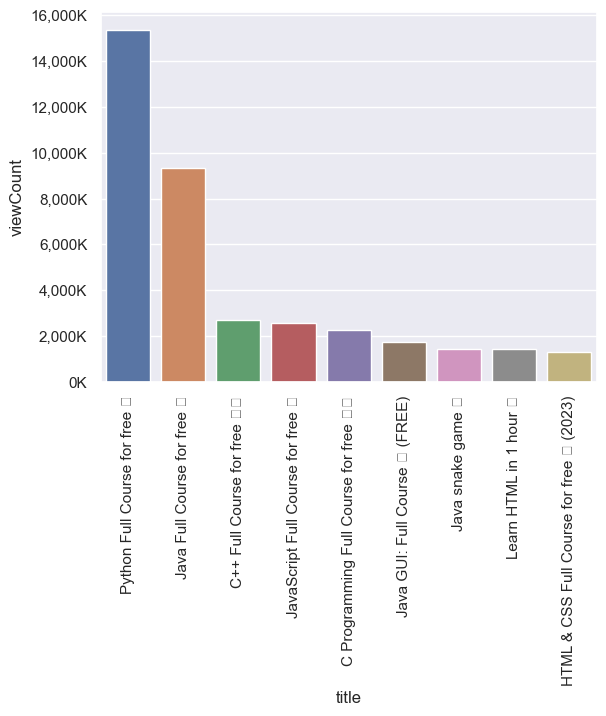

In [26]:
# Best performing videos

ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from current font.
  func(*args, **kwargs)
C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 128178 (\N{HEAVY DOLLAR SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from current font.
  func(*args, **kwargs)
C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 127909 (\N{MOVIE CAMERA}) missing from current font.
  func(*args, **kwargs)
C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 129412 (\N{UNICORN FACE}) missing from current font.
  func(*args, **kwargs)
C:\Users\mahas\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 128195 (\N{PAGE WITH CURL}) missing from current font.
  func(*args

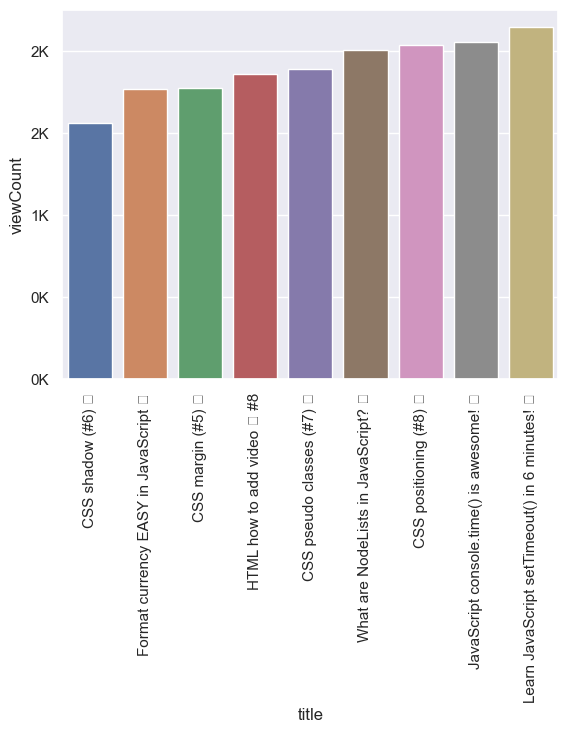

In [27]:
# Worst performing video

ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

<Axes: xlabel='channelTitle', ylabel='viewCount'>

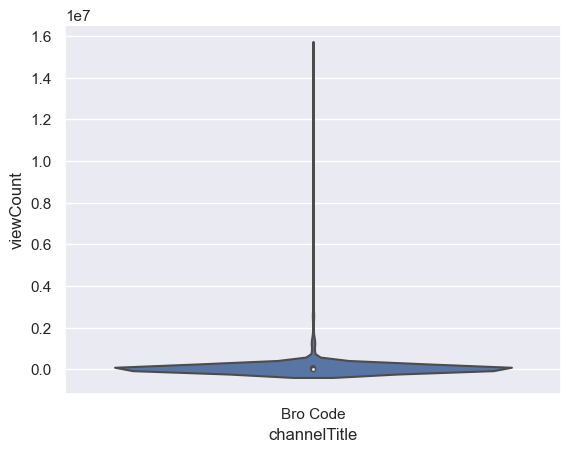

In [28]:
# View distribution per video

sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'])

<Axes: xlabel='likeCount', ylabel='viewCount'>

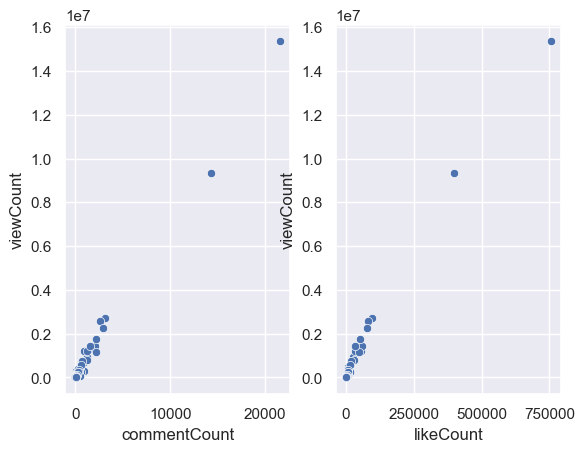

In [29]:
# Views vs likes and comments

fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax =ax[1])

<Axes: xlabel='durationSecs', ylabel='Count'>

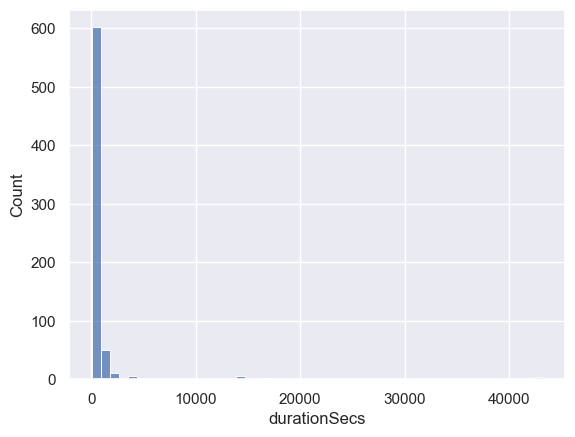

In [30]:
# Average video duration

sns.histplot(data = video_df, x = 'durationSecs', bins = 50)

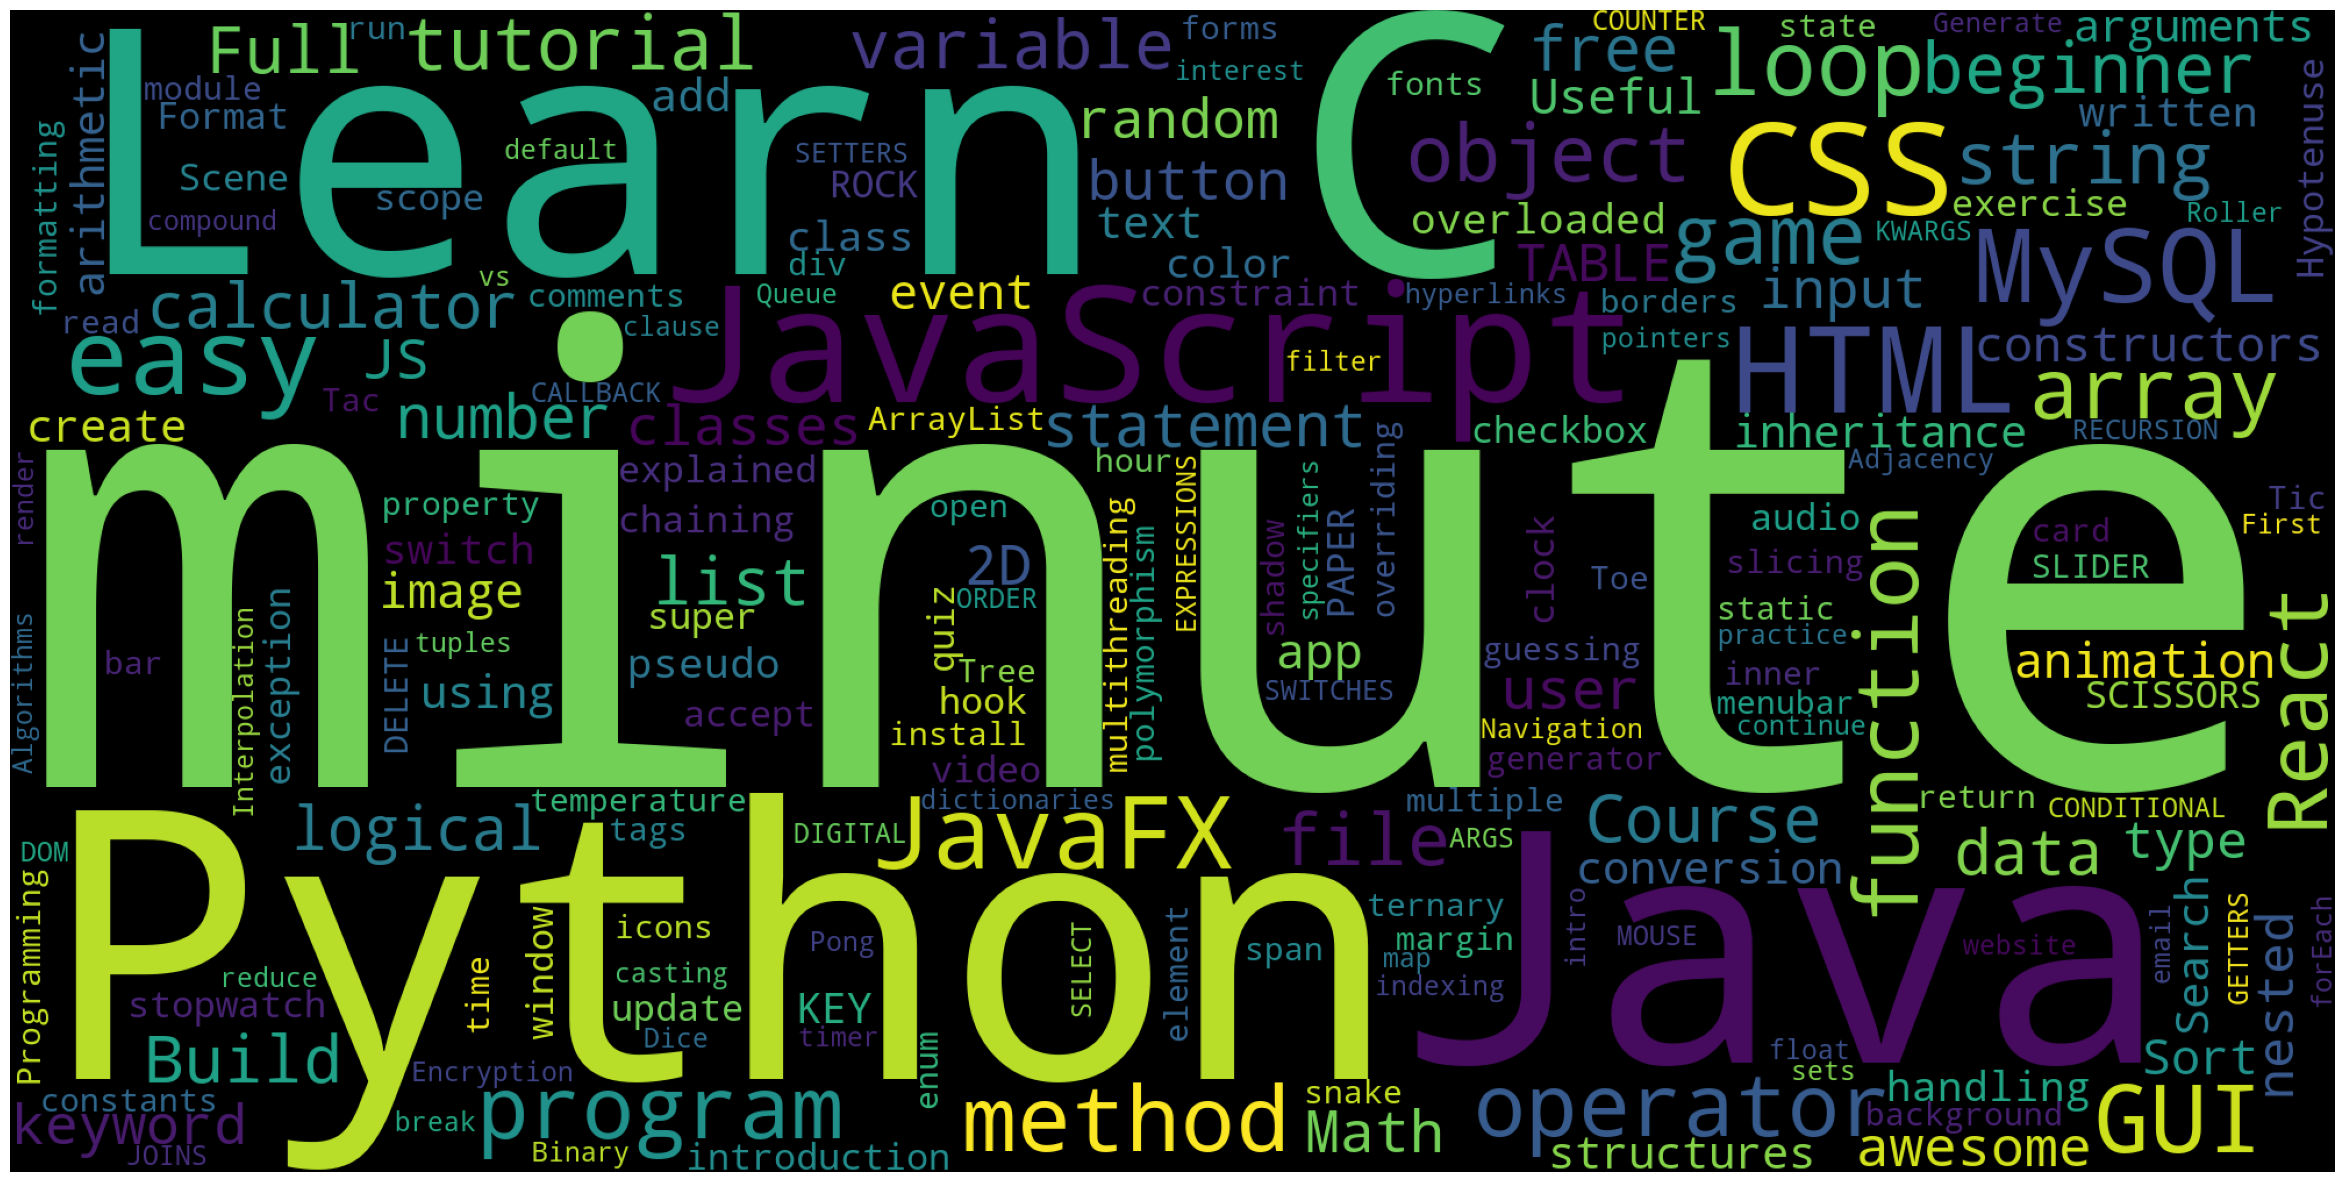

In [31]:
# Wordcloud for video titles

stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 


def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

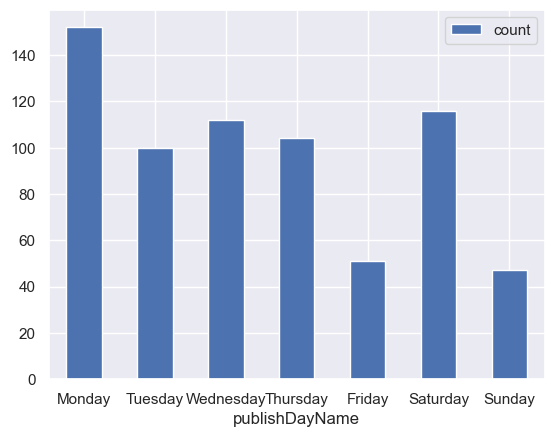

In [32]:
# Upload schedule

# which day in the week are most videos uploaded

day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reset the index and specify the name of the 'publishDayName' column as the index
day_df = day_df.reset_index().rename(columns={'index': 'publishDayName'})

# Reorder the DataFrame based on weekdays
day_df = day_df.set_index('publishDayName').reindex(weekdays)

# Plot the bar chart
ax = day_df.plot.bar(rot=0)

#day_df = day_df.reindex(weekdays)
#ax = day_df.reset_index().plot.bar(x = 'index', y = 'publishDayName', rot = 0)

# For multiple channels

In [33]:
# For multiple channels

api_service_name = "youtube"
api_version = "v3"
channel_ids = ['UC4SVo0Ue36XCfOyb5Lh1viQ','UCCgLoMYIyP0U56dEhEL1wXQ','UCovfq4h24UvKIju6kqqNu4A'] 
# Bro code, Chloe Ting, Great Indian ASMR

# Get credentials and create an API client

youtube = build(
    api_service_name, api_version, developerKey = api_key)
    

#print(response)
# JSON(response)

#formatted_response = json.dumps(response, indent=2)
#print(formatted_response)

In [34]:
def get_channel_stats1(youtube, channel_ids):
    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id= ','.join(channel_ids)

    )
    response = request.execute()

 # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return (pd.DataFrame(all_data))

In [35]:
channel_stats = get_channel_stats1(youtube, channel_ids)

In [36]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Bro Code,1560000,75996632,682,UU4SVo0Ue36XCfOyb5Lh1viQ
1,Great Indian Asmr,10300000,4811856796,238,UUovfq4h24UvKIju6kqqNu4A
2,Chloe Ting,25000000,3113790445,426,UUCgLoMYIyP0U56dEhEL1wXQ
